<center><h1>Implementation of SaShiMi</h1><h3>From paper <a href="https://arxiv.org/abs/2202.09729">It's Raw! Audio Generation with State-Space Models</a></h3></center>

**Paper authors:** Karan Goel, Albert Gu, Chris Donahue, Christopher Ré

**Code authors:** İlker Işık, Muhammed Can Keleş

# SaShiMi Architecture

SaSHimi is a method for generating raw audio. It is built around the recently introduced S4 model, which is designed for sequence processing tasks. Authors modify S4 for better stability and show state of the art results on multilpe audio domains, with less parameters and inference time.

Here, we borrow Figure 1 from the paper:

<img src="images/sashimi-architecture.png" alt="SaShiMi Figure"/>

## S4 Block

The main component of SaShiMi architecture is the **S4 Block**. The paper explains the details of S4 block in Appendix A.2.

### High-level Architecture

First pass:
1. Input
2. LayerNorm
3. S4 Layer
4. GELU
5. Linear
6. Residual connection from 1

Second pass:
1. Output of the first pass
2. LayerNorm
3. Linear
4. GELU
5. Linear
6. Residual connection from 1

All linear layers are position-wise, i.e., they operate on the signal dimensions, not
the time dimension.

## S4 Layer

At a high-level, S4 layer can be thought of as a mapping from a 1D sequence to another 1D sequence. Some of the important properties of S4:
- It's causal. The output at index $i$ depends on inputs from $0$ to $i-1$.
- It can be computed using either convolution or recurrence.
    - We use convolution during training and recurrence during sampling.
- Although it's 1D to 1D, we stack multiple S4 Layers together to process multidimensional signals.
    - In this case, different dimensions don't interact with each other.
    - Linear layers compute interactions between different signal dimensions but they cannot handle interactions through time. Therefore, linear layers complement S4 layers nicely.
- S4 doesn't provide non-linearity by itself. It needs to be combined with activation functions.

For more information, you can read the [paper](https://arxiv.org/abs/2202.09729) or the source code of our S4 implementation. Our code contains many docstrings and comments.

## State Space Models

S4 stands for **structured state-space model**. But what is a state space model?

A state space model (SSM) is a new class of deep neural network that exhibits the properties of both CNNs and RNNs. 
In continuous time, SSM can be defined as follows:

$$h'(t) = Ah(t) + Bx(t)$$
$$y(t) = Ch(t) + Dx(t)$$

We can discretize the matrices $A$, $B$, $C$ and $D$ as follows:

$$\overline{A} = (I - \Delta/2 \cdot A)^{-1}(I + \Delta/2 \cdot A)$$

Discretization formulas for $B$, $C$ and $D$ are similar. Once we obtain $\overline{A}$, $\overline{B}$, $\overline{C}$ and $\overline{D}$, the discretized system is:

$$h_{k} = \overline{A} h_{k-1} + \overline{B} x_k$$
$$y_k = \overline{C} h_k + \overline{D} x_k$$

This discretized system is evaluated in a recurrent manner. But we can compute the convolutional kernel $\overline{K}$:

$$\overline{K} =
  (\overline{C}\overline{B}, \overline{C}\overline{A}\overline{B}, \overline{C}\overline{A}^2\overline{B}, \ldots)$$

And using $\overline{K}$, computing $y$ from $x$ can be performed in a single convolution operation:

$$y = \overline{K} \ast x$$

## S4 Details

Despite their theoretically attractive properties, SSMs deliver disappointing performance in practice. S4 was originally developed to overcome these deficiencies.

S4 is a subset of SSM where the matrix $A$ is in _diagonal plus low-rank_ (DPLR) form, i.e., for a diagonal matrix $\Lambda$,

$$A = \Lambda + p q^*$$

Furthermore, in S4, the matrices $A$ (more specifically, $\Lambda$, $p$ and $q$) and $B$ are initialized according to **HiPPO**. HiPPO stands for **High-order Polynomial Projection Operator**. The state space model defined by HiPPO creates a lossy summary of the signal processed so far.

For more information on HiPPO, see the paper [HiPPO: Recurrent Memory with Optimal Polynomial Projections](https://arxiv.org/abs/2008.07669).

## Contributions to S4

In SaShiMi paper, the authors make several improvements to S4.

When sampling, the recurrent representation of S4 is unstable. The authors observe the source of unstability using state space theory and provide a simple S4 reparameterization that ensures stability theorically. In particular, they change the formulation of $A$ from $A = \Lambda + p q^*$ to

$$A = \Lambda - p p^*$$

There's also a **bidirectional S4** variant presented in the paper, which is simply the concatenation of two S4 layers but one of them is run in reverse order. However, it obviously breaks causality and hence it's not used for autoregressive tasks. Thus, we won't implement it in this notebook.

## Up-Pool and Down-Pool

The next components **up-pool** and **down-pool** are combinations of reshaping and a linear layer.

In particular, for an input of shape $(T, H)$ where $T$ is the sequence length (sample count) and $H$ is the signal dimension, the **down-pool** is

$$
(T,H) \xrightarrow{\text{reshape}} (T/p, H \cdot p) \xrightarrow{\text{linear}} (T/p, H \cdot q)
$$

where $p$ is the pooling factor and $q$ is the expansion factor.

**Up-pool** is simply the opposite operation:

$$
(T/p, H \cdot q) \xrightarrow{\text{linear}} (T/p, H \cdot p) \xrightarrow{\text{reshape}} (T,H)
$$

They use $p=4$ and $q=2$ in the paper.

Note that we use our own `Sequential` implementation instead of `torch.nn.Sequential`. Our implementation inherits `torch.nn.Sequential` and accounts for the S4 layer when we want to run it in recurrent mode. `Residual` is the same as `Sequential` but it applies a residual connection from the beginning to the end, i.e., $Residual(x) = x + Sequential(x)$.

# Prelude

Before starting, follow the instructions in README and make sure that:
1. The required libraries given in README are installed.
2. You have downloaded the datasets and pretrained models.

In the following code blocks, we will setup, import modules, select device, etc.

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

The dataset is actually just the audio track of [this 4 hour piano video from YouTube](https://www.youtube.com/watch?v=EhO_MrRfftU). It's resampled at 16 kHz and divided into 1 minute WAV files. Thankfully, the authors of the paper have already done this step and uploaded the processed dataset [here on HuggingFace](https://huggingface.co/datasets/krandiash/youtubemix).

In [4]:
DURATION = 8
train_dataset = YoutubeMixDataset("./datasets/youtube-mix/train", duration=DURATION, device=device)

In [5]:
len(train_dataset)

1589

In [8]:
# Check sample rate
assert train_dataset.sample_rate == 16000

x, y = train_dataset[0]
assert list(x.size()) == [DURATION * 16000]
assert list(y.size()) == [DURATION * 16000]

`y` contains all samples 0 to N in the sound file, each sample is an integer between 0 and 255. `x`, on the other hand, contains samples 0 to N-1, each sample is an integer between 0 to 255. For each input sample $i$, the network predicts the probabilities for the next sample ($i+1$) in 8-bits using the inputs from $0$ to $i$.

Let's listen to one of the sound files in the dataset:

In [9]:
ipd.Audio(mu_law_decoding(x, 256).cpu().numpy(), rate=16000)

# The Model

Here, we define the SaShiMi model with the hyperparameters given in Appendix C.2.1.

In [10]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*DURATION,
    block_count=4,
    encoder=Embedding(256, 64),
).to(device)

For "simplicity", they don't train the low-rank term $pp^*$, the $B$ matrix and the timescale $\Delta$. In some of our full dataset experiments, we do the same, but we still train $\Delta$ because they don't provide the initial value for that parameter.

However, we found that freezing these parameters is highly detrimental in overfitting test. Therefore, we won't do that here.

In [11]:
for module in model.modules():
    # isinstance doesn't work due to automatic reloading
    if type(module).__name__ == S4Base.__name__:
        module.B.requires_grad = False
        module.P.requires_grad = False

Let's inspect the number of parameters in our model:

In [12]:
print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 2332300
Parameters to be learned: 2101388


# Training the Model: Overfitting Test

In accordance with the well-respected 796 tradition, we first test whether the model works by trying to overfit into a single example.

In [13]:
x, y = train_dataset[0]
overfit_dataset = [(x, y)]

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/500 [00:00<?, ?it/s]

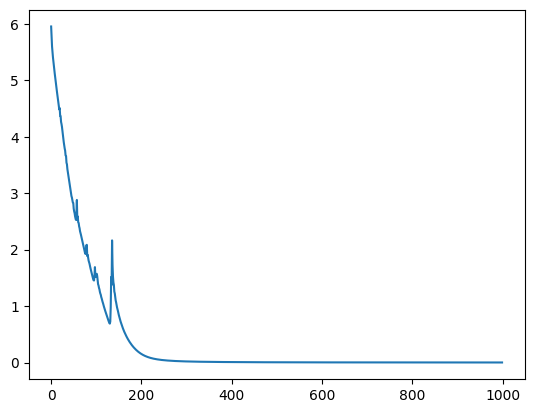

0.0007383343763649464

In [19]:
model.train()
for epoch in tqdm(range(1000), leave=False):
    for x, y in overfit_dataset:
        y_hat = model(x)
        loss = criterion(y_hat.view(-1, 256), y.view(-1))

        loss_val = loss.detach().cpu().item()
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()
losses[-1]

Note that even though the loss seems flat in the last half of the training, it makes a huge difference while sampling.

## Sampling

The following method will autoregressively sample from the given model `m`. It can optionally use a priming signal to start with. When `maxp` is `True`, it will always choose the value with highest probability instead of random sampling.

In [4]:
def generate_sample(m, count: int, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # Pad the input with 0 sample to get started.
    u = f(mu_law_encoding(torch.zeros(1, device=device), 256))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s)
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in tqdm(range(count - primed_size), leave=False):
        if maxp:
            p = torch.argmax(u)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        Y.append(p)
        u = p.reshape(1)
        u = f(u)

    generated = torch.stack(Y).real
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        return torch.cat([priming_signal, generated], dim=0)
    else:
        return generated

Let's generate a sample and listen to it:

  0%|          | 0/128000 [00:00<?, ?it/s]

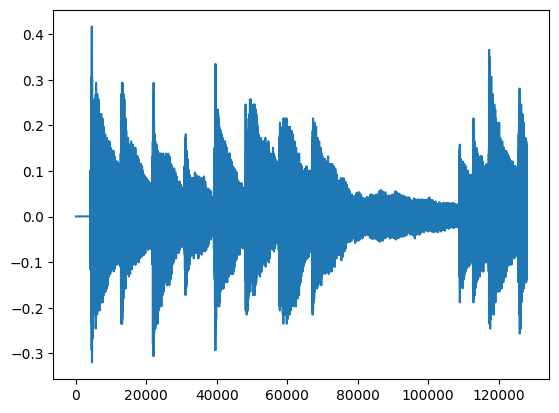

In [22]:
torch.manual_seed(42)
model.eval()
with torch.no_grad():
    gen = generate_sample(model, 8*16000, maxp=True).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

We can also save it as WAV:

In [ ]:
wavfile.write("overfitting.wav", 16000, gen.flatten().numpy())

# Full Dataset Training

Since training on the full dataset takes a lot of time, we won't demonstrate it in this notebook. The training script is available in the repository, see `README.md` for details.

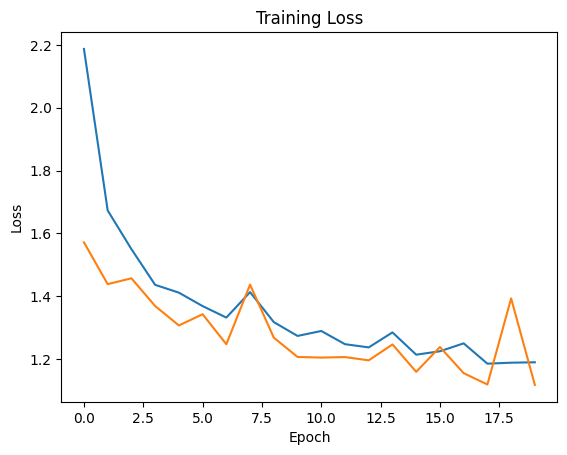

In [7]:
train = [2.1868624687194824, 1.6732466220855713, 1.5502313375473022, 1.4366320371627808, 1.4118376970291138, 1.3690325021743774, 1.332533836364746, 1.4135502576828003, 1.3181391954421997, 1.2741639614105225, 1.2898980379104614, 1.2479090690612793, 1.237662434577942, 1.2854124307632446, 1.2145167589187622, 1.2254503965377808, 1.2505583763122559, 1.1859673261642456, 1.1890779733657837, 1.1903769969940186]
valid = [1.5717824697494507, 1.4388880729675293, 1.4574099779129028, 1.3692907094955444, 1.3074723482131958, 1.3432033061981201, 1.2477797269821167, 1.437267541885376, 1.268721342086792, 1.2072551250457764, 1.205346703529358, 1.2069224119186401, 1.1965463161468506, 1.2471457719802856, 1.1599700450897217, 1.2389296293258667, 1.1557605266571045, 1.1196863651275635, 1.3935421705245972, 1.1183758974075317]

plt.title(label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train)
plt.plot(valid)

# Loading a Pre-Trained Model

Let's load the second pre-trained model. Note that you should have downloaded this model using `download_data.sh`.
Note that there are other pre-trained models in `models` folder.

In [5]:
checkpoint = torch.load("./models/ym-1/epoch0020.pt", map_location=device)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=8,
    encoder=Embedding(256, 64),
).to(device)

model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

Now, let's sample from this model that has been trained on the full YouTube Mix dataset.

  0%|          | 0/128000 [00:00<?, ?it/s]

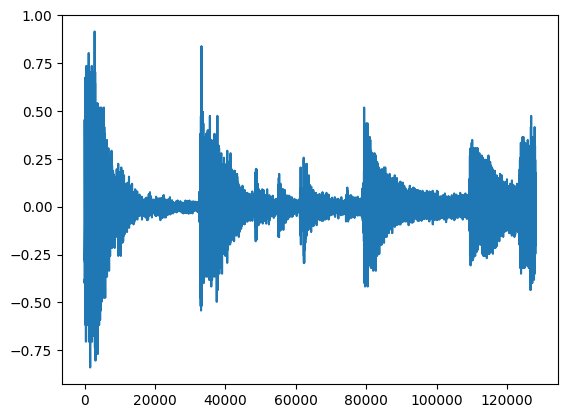

In [6]:
torch.manual_seed(42)
model.eval()
with torch.no_grad():
    #gen = generate_sample(model, 2*16000, train_dataset[1][0][:8000])
    gen = generate_sample(model, 8*16000).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

In [8]:
wavfile.write("outputs/ym-1/epoch20-seed42.wav", 16000, gen.flatten().numpy())

# Reproducing the Results

By sampling from the model in the previous section, we have seen some qualitative results.

## NLL Test

Next, we will compute negative log likelihood (NLL) values on the test dataset.

In [9]:
test_dataset = YoutubeMixDataset("./datasets/youtube-mix/test", duration=8, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_dataset)

111

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

Note that PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [10]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    nll = 0.0
    for x, y in tqdm(test_dataloader, leave=False):
        y_hat = model(x)
        nll += criterion(y_hat.view(-1, 256), y.view(-1))
    nll /= len(test_dataloader)

    print("Average NLL:", nll.item())
    print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
    print("Average NLL converted to probability:", (-nll).exp().item())

  0%|          | 0/111 [00:00<?, ?it/s]

Average NLL: 1.1359831094741821
Average NLL in base 2: 1.6388771533966064
Average NLL converted to probability: 0.32110628485679626


# Challenges

In this section, we list the challenges we faced while implementing the paper:

1. The details of S4 are not given in the SaShiMi paper. We had to go back to the S4's paper and implement it from scratch, which took most of our time. It was like implementing two papers at once.
2. While describing the model structure in Appendix C.2.1, the authors provide the "model dimension", but it's unclear whether this term refers to the hidden dimension of the signal or the state dimensions (size of $x$ computed by $A$ and $B$ matrices). We set both of these values to 64 in our experiments. Because we found that when they are both 64, the number of parameters of our model is similar to the values given in Table 5.
3. The authors give the learning rate for SaShiMi model, but they don't tell the name of the optimizer. We used `Adam` in all of our experiments.
4. Although we obtained great results on MNIST dataset, our results on the target dataset (Youtube Mix) are disappointing. This might be simply because we couldn't train for long enough (they train for 600K iterations, which translates to ~400 epochs). Or they might have used a different optimizer.
5. Using large context sizes during training (e.g. 8 seconds at 16000 Hz) leads to numerical issues (sometimes we obtain NaNs due to matrix power operation) and out of memory errors despite using PyKeOps.

We are fairly confident that our model works correctly, as shown in our unit tests and MNIST experiments. However, training SaShiMi and S4-based models in general proved to be an immensely difficult task, especially in datasets with long contexts.